In [44]:
# hide
import graphviz

def create_layer(dot, x, ys, names, prefix, label=None):
    assert(len(ys) == len(names))
    if label:
        dot.node(prefix+'-1', label, shape="none", pos="{},{}!".format(x, ys[0] + 0.4))
    tags = [prefix + str(i) for i in range(len(names))]
    for tag, name, y in zip(tags, names, ys):
        dot.node(tag, name, shape="square",
                pos="{},{}!".format(x, y))
    return tags

def create_arrows(dot, starts, ends, names=None):
    if names:
        assert(len(starts) * len(ends) == len(names))
    else:
        names = [None] * (len(starts)*len(ends))
    index = 0
    for e in ends:
        for s in starts:
            dot.edge(s, e, label=names[index])
            index += 1

def create_layer2(dot, x, n_in, off_y, d_y, format, l_name, label=None):
    return create_layer(dot, x, 
        [i * d_y + off_y for i in range(n_in)],
        [format.format(i) for i in range(n_in)], l_name, label)

def create_nn2(n_in, n_out):
    dot = graphviz.Digraph('nn', engine='neato')

    input = create_layer2(dot, 0, n_in, 0, -0.7, "X[{}]", "input", label="入力")
    output = create_layer2(dot, 3, n_out, -1.05, -1, "ŷ", "o", label="出力")
    create_arrows(dot, input, output, 
            names=['w[{}]'.format(i) for i in range(len(input))])
    return dot

def create_nn3(n_in, n_hidden, n_out):
    dot = graphviz.Digraph('nn', engine='neato')

    input = create_layer2(dot, 0, n_in, 0, -0.7, "X[{}]", "input", label="入力")
    hidden = create_layer2(dot, 2, n_hidden, -0.35, -0.7, "h[{}]", "h", label="隠れ層")
    output = create_layer2(dot, 4, n_out, -1.05, -1, "ŷ", "o", label="出力")

    create_arrows(dot, input, hidden)
    create_arrows(dot, hidden, output)
            
    return dot

def create_nn4(n_in, n_h1, n_h2, n_out):
    dot = graphviz.Digraph('nn', engine='neato')

    input = create_layer2(dot, 0, n_in, 0, -0.7, "X[{}]", "input", label="入力")
    hidden1 = create_layer2(dot, 2, n_h1, -0.35, -0.7, "h1[{}]", "h1", label="隠れ層1")
    hidden2 = create_layer2(dot, 4, n_h2, -0.35, -0.7, "h2[{}]", "h2", label="隠れ層2")
    output = create_layer2(dot, 6, n_out, -1.05, -1, "ŷ", "o", label="出力")

    create_arrows(dot, input, hidden1)
    create_arrows(dot, hidden1, hidden2)
    create_arrows(dot, hidden2, output)
            
    return dot

#create_nn2(4, 1)
#create_nn3(4, 3, 1)
#create_nn4(4, 3, 3, 1)


In [50]:
# hide
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plt_predict(model, axe, X, title):
    xmin, xmax, ymin, ymax = X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max(), 
    grid = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/300.0), 
                       np.arange(ymin, ymax, (ymax-ymin)/300.0), indexing='xy')
    g = [[x, y] for x, y in zip(np.hstack(grid[0]), np.hstack(grid[1]))]
    p_g = model.predict(g)
    axe.scatter(grid[0], grid[1], c = p_g, cmap=cm.Pastel1, s = 1)
    axe.set_title(title)


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


### 2.2.5 ニューラルネットワーク



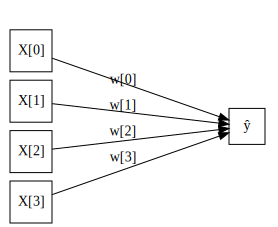

In [47]:
create_nn2(4, 1)

#### 活性化関数
- ニューラルネットワークの各層は線形変換
    - 線形変換は何度行っても線形変換にしかならない
    - 何層線形変換層があっても同じ
- 層と層の間で非線形変換を挟む
    - 活性化関数(activation function)と呼ぶ
    - 代表的なもの
        - ReLU - Rectified Linear Unit
        - tanh - Hyperbolic tangent
        - sigmoid
- どれを使ってもそれほど大きく結果は変わらない

'代表的な活性化関数'

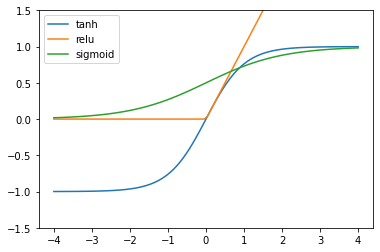

In [100]:
# hide
import matplotlib.pyplot as plt
import numpy as np

line = np.linspace(-4, 4, 100)
plt.plot(line, np.tanh(line), label="tanh")
plt.plot(line, np.maximum(line, 0), label="relu")
plt.plot(line, 1.0 / (1.0 + np.exp(- line)), label="sigmoid")
plt.ylim(-1.5, 1.5)
plt.legend()
"代表的な活性化関数"


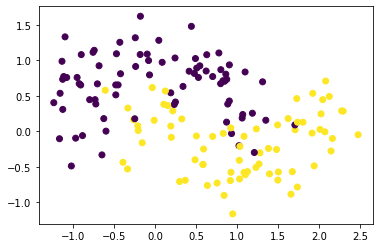

In [51]:
# データの生成と表示
X, y = make_moons(n_samples=200, noise=0.3, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)



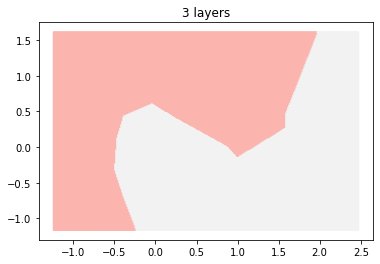

In [92]:
from sklearn.neural_network import MLPClassifier

# mdl = MLPClassifier(solver='lbfgs', hidden_layer_sizes=[10], max_iter=500)

mdl = MLPClassifier(solver='lbfgs', hidden_layer_sizes=[10,10,10], activation='relu', max_iter=100000)
mdl.fit(X_train, y_train)

plt_predict(mdl, plt.gca(), X_train, '3 layers')
